### Import Packages

In [21]:
import os
import sys

# !pip install xarray

import numpy as np
import pandas as pd
from datetime import datetime
import pdb
import xarray as xr
import matplotlib.pyplot as plt

import solo
from KNMI_readers import read_knmi_uurgeg

sys.path.append(r'c:\checkouts\python\TUD-COASTAL\python')

In [22]:
dsp1 = xr.open_dataset(f'ps_data/raw_data/ps1/raw_netcdf/ps1_20230923.nc')
instr1 = dsp1.instrument

dsp2 = xr.open_dataset(f'ps_data/raw_data/ps2/raw_netcdf/ps2_20230923.nc')
instr2 = dsp2.instrument

dsp3 = xr.open_dataset(f'ps_data/raw_data/ps3/raw_netcdf/ps3_20230923.nc')
instr3 = dsp3.instrument

dsp4 = xr.open_dataset(f'ps_data/raw_data/ps4/raw_netcdf/ps4_20230923.nc')
instr4 = dsp4.instrument

dsp5 = xr.open_dataset(f'ps_data/raw_data/ps5/raw_netcdf/ps5_20230923.nc')
instr5 = dsp5.instrument

dsp6 = xr.open_dataset(f'ps_data/raw_data/ps6/raw_netcdf/ps6_20230923.nc')
instr6 = dsp6.instrument

### Correct for air pressure fluctuations
Air pressure fluctuations are removed from the pressure signal.

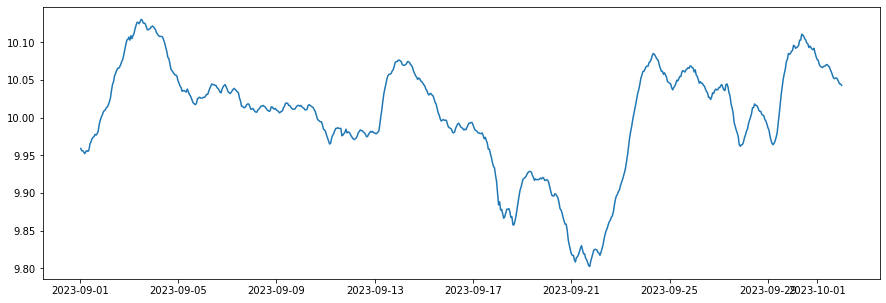

In [23]:
# from KNMI_readers import read_knmi_uurgeg (done at the top)

knmiFile = "atm_ps_data/uurwaarden_atm_pressure.txt"

# correct for the air pressure fluctuations and drift in the instrument
# first we load the data and add it to the dataset

dfp = read_knmi_uurgeg(knmiFile, stationNumber=330)

# display(dfp)

plt.figure(figsize=(15,5))
plt.plot(dfp.index, dfp.P/(1035*9.81))

In [24]:
rho_sea = 1035  # kg/m3
g = 9.81  # m/s2

# placeholders
# zb = -0.5
# zi = -0.38


dt1 = ((dsp1.t[1] - dsp1.t[0]) / np.timedelta64(1, 's')).values # target frequency
dt2 = ((dsp2.t[1] - dsp2.t[0]) / np.timedelta64(1, 's')).values # target frequency
dt3 = ((dsp3.t[1] - dsp3.t[0]) / np.timedelta64(1, 's')).values # target frequency
dt4 = ((dsp4.t[1] - dsp4.t[0]) / np.timedelta64(1, 's')).values # target frequency
dt5 = ((dsp5.t[1] - dsp5.t[0]) / np.timedelta64(1, 's')).values # target frequency
dt6 = ((dsp6.t[1] - dsp6.t[0]) / np.timedelta64(1, 's')).values # target frequency

pAir1 = dfp['P'].to_xarray().resample({'t': '{}S'.format(dt1)}). \
        interpolate('linear').sel(t=slice(dsp1.t.min(), dsp1.t.max()))
pAir2 = dfp['P'].to_xarray().resample({'t': '{}S'.format(dt2)}). \
        interpolate('linear').sel(t=slice(dsp2.t.min(), dsp2.t.max()))
pAir3 = dfp['P'].to_xarray().resample({'t': '{}S'.format(dt3)}). \
        interpolate('linear').sel(t=slice(dsp3.t.min(), dsp3.t.max()))
pAir4 = dfp['P'].to_xarray().resample({'t': '{}S'.format(dt4)}). \
        interpolate('linear').sel(t=slice(dsp4.t.min(), dsp4.t.max()))
pAir5 = dfp['P'].to_xarray().resample({'t': '{}S'.format(dt5)}). \
        interpolate('linear').sel(t=slice(dsp5.t.min(), dsp5.t.max()))
pAir6 = dfp['P'].to_xarray().resample({'t': '{}S'.format(dt6)}). \
        interpolate('linear').sel(t=slice(dsp6.t.min(), dsp6.t.max()))

dsp1['pAir'] = pAir1.sel(t=slice(dsp1.t.min(), dsp1.t.max()))
dsp2['pAir'] = pAir2.sel(t=slice(dsp2.t.min(), dsp2.t.max()))
dsp3['pAir'] = pAir3.sel(t=slice(dsp3.t.min(), dsp3.t.max()))
dsp4['pAir'] = pAir4.sel(t=slice(dsp4.t.min(), dsp4.t.max()))
dsp5['pAir'] = pAir5.sel(t=slice(dsp5.t.min(), dsp5.t.max()))
dsp6['pAir'] = pAir6.sel(t=slice(dsp6.t.min(), dsp6.t.max()))

In [25]:
# we correct for drift in air pressure, nothing else
dsp1['dpAir'] = dsp1['pAir'] - dsp1['pAir'].sel(t=datetime.strptime('2023-09-29 11:10:00', '%Y-%m-%d %H:%M:%S'))
dsp2['dpAir'] = dsp2['pAir'] - dsp2['pAir'].sel(t=datetime.strptime('2023-09-29 11:10:00', '%Y-%m-%d %H:%M:%S'))
dsp3['dpAir'] = dsp3['pAir'] - dsp3['pAir'].sel(t=datetime.strptime('2023-09-29 11:10:00', '%Y-%m-%d %H:%M:%S'))
dsp4['dpAir'] = dsp4['pAir'] - dsp4['pAir'].sel(t=datetime.strptime('2023-09-29 11:10:00', '%Y-%m-%d %H:%M:%S'))
dsp5['dpAir'] = dsp5['pAir'] - dsp5['pAir'].sel(t=datetime.strptime('2023-09-29 11:10:00', '%Y-%m-%d %H:%M:%S'))
dsp6['dpAir'] = dsp6['pAir'] - dsp6['pAir'].sel(t=datetime.strptime('2023-09-29 11:10:00', '%Y-%m-%d %H:%M:%S'))

In [26]:
# calculate drift instrument pressure
def get_drift(dsp, tmin, tmax, calibration_depth=0.08, rho_sea=1035, g=9.81):
    
    # tmin1 = datetime.strptime('2023-09-29 08:00:00', '%Y-%m-%d %H:%M:%S')
    # tmax1 = datetime.strptime('2023-09-29 12:00:00', '%Y-%m-%d %H:%M:%S')
    
    ts = slice(np.array(tmin), np.array(tmax))
    
    ps = dsp.sel(t=ts).p.values.mean()
    
    drift = ps - rho_sea * g * calibration_depth
    
    return drift

tbegin = datetime.strptime('2023-09-29 11:09:30', '%Y-%m-%d %H:%M:%S')
tend   = datetime.strptime('2023-09-29 11:11:00', '%Y-%m-%d %H:%M:%S')

drift1 = get_drift(dsp1, tmin=tbegin, tmax=tend)
drift2 = get_drift(dsp2, tmin=tbegin, tmax=tend)
drift3 = get_drift(dsp3, tmin=tbegin, tmax=tend)
drift4 = get_drift(dsp4, tmin=tbegin, tmax=tend)
drift5 = get_drift(dsp5, tmin=tbegin, tmax=tend)
drift6 = get_drift(dsp6, tmin=tbegin, tmax=tend)


# plt.plot(dsp1.sel(t=slice(np.array(tbegin), np.array(tend))).t, dsp1.sel(t=slice((np.array(tbegin),np.array(tend)))).p)

In [27]:
# correct the pressure signal with dpAir and with drift in instrument pressure
dsp1['pc'] = (dsp1['p'] - drift1) - dsp1['dpAir']
dsp2['pc'] = (dsp2['p'] - drift2) - dsp2['dpAir']
dsp3['pc'] = (dsp3['p'] - drift3) - dsp3['dpAir']
dsp4['pc'] = (dsp4['p'] - drift4) - dsp4['dpAir']
dsp5['pc'] = (dsp5['p'] - drift5) - dsp5['dpAir']
dsp6['pc'] = (dsp6['p'] - drift6) - dsp6['dpAir']

dsp1['pc'].attrs = {'units': 'Pa + NAP', 'long_name': 'pressure','comments': 'drift in air pressure is corrected'}
dsp2['pc'].attrs = {'units': 'Pa + NAP', 'long_name': 'pressure','comments': 'drift in air pressure is corrected'}
dsp3['pc'].attrs = {'units': 'Pa + NAP', 'long_name': 'pressure','comments': 'drift in air pressure is corrected'}
dsp4['pc'].attrs = {'units': 'Pa + NAP', 'long_name': 'pressure','comments': 'drift in air pressure is corrected'}
dsp5['pc'].attrs = {'units': 'Pa + NAP', 'long_name': 'pressure','comments': 'drift in air pressure is corrected'}
dsp6['pc'].attrs = {'units': 'Pa + NAP', 'long_name': 'pressure','comments': 'drift in air pressure is corrected'}

### Bed level and instrument level
We also import bed level and instrument level here.

In [28]:
# define z-level of bed and instrument
dfz = pd.read_csv("Pole Data.csv", delimiter=';', decimal=',', parse_dates=['t'], index_col='t')

# display(dfz)

zi1 = dfz['zi1'].to_xarray().resample({'t': '{}S'.format(dt1)}). \
        interpolate('linear').sel(t=slice(dsp1.t.min(), dsp1.t.max()))
zb1 = dfz['zb1'].to_xarray().resample({'t': '{}S'.format(dt1)}). \
        interpolate('linear').sel(t=slice(dsp1.t.min(), dsp1.t.max())) #+ 0.1

zi2 = dfz['zi2'].to_xarray().resample({'t': '{}S'.format(dt2)}). \
        interpolate('linear').sel(t=slice(dsp2.t.min(), dsp2.t.max()))
zb2 = dfz['zb2'].to_xarray().resample({'t': '{}S'.format(dt2)}). \
        interpolate('linear').sel(t=slice(dsp2.t.min(), dsp2.t.max())) #+ 0.1

zi3 = dfz['zi3'].to_xarray().resample({'t': '{}S'.format(dt3)}). \
        interpolate('linear').sel(t=slice(dsp3.t.min(), dsp3.t.max()))
zb3 = dfz['zb3'].to_xarray().resample({'t': '{}S'.format(dt3)}). \
        interpolate('linear').sel(t=slice(dsp3.t.min(), dsp3.t.max())) #+ 0.1

zi4 = dfz['zi4'].to_xarray().resample({'t': '{}S'.format(dt4)}). \
        interpolate('linear').sel(t=slice(dsp4.t.min(), dsp4.t.max()))
zb4 = dfz['zb4'].to_xarray().resample({'t': '{}S'.format(dt4)}). \
        interpolate('linear').sel(t=slice(dsp4.t.min(), dsp4.t.max())) #+ 0.1

zi5 = dfz['zi5'].to_xarray().resample({'t': '{}S'.format(dt5)}). \
        interpolate('linear').sel(t=slice(dsp5.t.min(), dsp5.t.max()))
zb5 = dfz['zb5'].to_xarray().resample({'t': '{}S'.format(dt5)}). \
        interpolate('linear').sel(t=slice(dsp5.t.min(), dsp5.t.max())) #+ 0.1

zi6 = dfz['zi6'].to_xarray().resample({'t': '{}S'.format(dt6)}). \
        interpolate('linear').sel(t=slice(dsp6.t.min(), dsp6.t.max()))
zb6 = dfz['zb6'].to_xarray().resample({'t': '{}S'.format(dt6)}). \
        interpolate('linear').sel(t=slice(dsp6.t.min(), dsp6.t.max())) #+ 0.1


dsp1['zi'] = zi1.sel(t=slice(dsp1.t.min(), dsp1.t.max()))
dsp1['zb'] = zb1.sel(t=slice(dsp1.t.min(), dsp1.t.max()))

dsp2['zi'] = zi2.sel(t=slice(dsp2.t.min(), dsp2.t.max()))
dsp2['zb'] = zb2.sel(t=slice(dsp2.t.min(), dsp2.t.max()))

dsp3['zi'] = zi3.sel(t=slice(dsp3.t.min(), dsp3.t.max()))
dsp3['zb'] = zb3.sel(t=slice(dsp3.t.min(), dsp3.t.max()))

dsp4['zi'] = zi4.sel(t=slice(dsp4.t.min(), dsp4.t.max()))
dsp4['zb'] = zb4.sel(t=slice(dsp4.t.min(), dsp4.t.max()))

dsp5['zi'] = zi5.sel(t=slice(dsp5.t.min(), dsp5.t.max()))
dsp5['zb'] = zb5.sel(t=slice(dsp5.t.min(), dsp5.t.max()))

dsp6['zi'] = zi6.sel(t=slice(dsp6.t.min(), dsp6.t.max()))
dsp6['zb'] = zb6.sel(t=slice(dsp6.t.min(), dsp6.t.max()))


dsp1['zi'].attrs = {'units': 'm + NAP', 'long_name': 'instrument level w.r.t. reference'}
dsp1['zb'].attrs = {'units': 'm + NAP', 'long_name': 'bed level w.r.t. reference'}

dsp2['zi'].attrs = {'units': 'm + NAP', 'long_name': 'instrument level w.r.t. reference'}
dsp2['zb'].attrs = {'units': 'm + NAP', 'long_name': 'bed level w.r.t. reference'}

dsp3['zi'].attrs = {'units': 'm + NAP', 'long_name': 'instrument level w.r.t. reference'}
dsp3['zb'].attrs = {'units': 'm + NAP', 'long_name': 'bed level w.r.t. reference'}

dsp4['zi'].attrs = {'units': 'm + NAP', 'long_name': 'instrument level w.r.t. reference'}
dsp4['zb'].attrs = {'units': 'm + NAP', 'long_name': 'bed level w.r.t. reference'}

dsp5['zi'].attrs = {'units': 'm + NAP', 'long_name': 'instrument level w.r.t. reference'}
dsp5['zb'].attrs = {'units': 'm + NAP', 'long_name': 'bed level w.r.t. reference'}

dsp6['zi'].attrs = {'units': 'm + NAP', 'long_name': 'instrument level w.r.t. reference'}
dsp6['zb'].attrs = {'units': 'm + NAP', 'long_name': 'bed level w.r.t. reference'}

In [29]:
# experimentFolder = 'ps_data/atm_pressure_removed_ts/'
 
# dsp1.to_netcdf(os.path.join(experimentFolder, instr1 + '.nc'))
# dsp2.to_netcdf(os.path.join(experimentFolder, instr2 + '.nc'))
# dsp3.to_netcdf(os.path.join(experimentFolder, instr3 + '.nc'))
# dsp4.to_netcdf(os.path.join(experimentFolder, instr4 + '.nc'))
# dsp5.to_netcdf(os.path.join(experimentFolder, instr5 + '.nc'))
# dsp6.to_netcdf(os.path.join(experimentFolder, instr6 + '.nc'))

### Reshape into bursts
Reshape the data into bursts (called blocks in ocean waves course)

In [30]:
# reshape to one row per burst in data array
pt = dsp1.pc.values
zit = dsp1.zi.values
zbt = dsp1.zb.values

nSamples = len(pt)
dt = dsp1.isel(t=1).t - dsp1.isel(t=0).t
sf = np.timedelta64(1, 's') / dt.values

burstDuration = pd.Timedelta('600S')
burstLength = int(burstDuration / dt)
nBursts = int(np.floor(nSamples / burstLength))

pt = pt[:nBursts * burstLength]
zit = zit[:nBursts * burstLength]
zbt = zbt[:nBursts * burstLength]

t = dsp1.t[::burstLength]
t = t[:nBursts]
N = (dsp1.t.values[:burstLength] - dsp1.t.values[0]) / np.timedelta64(1, 's')
# pdb.set_trace()

# cast into a 2D array
ds1 = xr.Dataset(data_vars={},
                coords={'t': t, 'N': N})

# copy all data over into this new structure
ds1['p'] = (('t', 'N'), pt.reshape((nBursts, burstLength)))
ds1['zi'] = (('t', 'N'), zit.reshape((nBursts, burstLength)))
ds1['zb'] = (('t', 'N'), zbt.reshape((nBursts, burstLength)))
ds1['sf'] = sf

In [31]:
# reshape to one row per burst in data array
pt = dsp2.pc.values
zit = dsp2.zi.values
zbt = dsp2.zb.values

nSamples = len(pt)
dt = dsp2.isel(t=1).t - dsp2.isel(t=0).t
sf = np.timedelta64(1, 's') / dt.values

burstDuration = pd.Timedelta('600S')
burstLength = int(burstDuration / dt)
nBursts = int(np.floor(nSamples / burstLength))

pt = pt[:nBursts * burstLength]
zit = zit[:nBursts * burstLength]
zbt = zbt[:nBursts * burstLength]

t = dsp2.t[::burstLength]
t = t[:nBursts]
N = (dsp2.t.values[:burstLength] - dsp2.t.values[0]) / np.timedelta64(1, 's')
# pdb.set_trace()

# cast into a 2D array
ds2 = xr.Dataset(data_vars={},
                coords={'t': t, 'N': N})

# copy all data over into this new structure
ds2['p'] = (('t', 'N'), pt.reshape((nBursts, burstLength)))
ds2['zi'] = (('t', 'N'), zit.reshape((nBursts, burstLength)))
ds2['zb'] = (('t', 'N'), zbt.reshape((nBursts, burstLength)))
ds2['sf'] = sf

In [32]:
# reshape to one row per burst in data array
pt = dsp3.pc.values
zit = dsp3.zi.values
zbt = dsp3.zb.values

nSamples = len(pt)
dt = dsp3.isel(t=1).t - dsp3.isel(t=0).t
sf = np.timedelta64(1, 's') / dt.values

burstDuration = pd.Timedelta('600S')
burstLength = int(burstDuration / dt)
nBursts = int(np.floor(nSamples / burstLength))

pt = pt[:nBursts * burstLength]
zit = zit[:nBursts * burstLength]
zbt = zbt[:nBursts * burstLength]

t = dsp3.t[::burstLength]
t = t[:nBursts]
N = (dsp3.t.values[:burstLength] - dsp3.t.values[0]) / np.timedelta64(1, 's')
# pdb.set_trace()

# cast into a 2D array
ds3 = xr.Dataset(data_vars={},
                coords={'t': t, 'N': N})

# copy all data over into this new structure
ds3['p'] = (('t', 'N'), pt.reshape((nBursts, burstLength)))
ds3['zi'] = (('t', 'N'), zit.reshape((nBursts, burstLength)))
ds3['zb'] = (('t', 'N'), zbt.reshape((nBursts, burstLength)))
ds3['sf'] = sf

In [33]:
# reshape to one row per burst in data array
pt = dsp4.pc.values
zit = dsp4.zi.values
zbt = dsp4.zb.values

nSamples = len(pt)
dt = dsp4.isel(t=1).t - dsp4.isel(t=0).t
sf = np.timedelta64(1, 's') / dt.values

burstDuration = pd.Timedelta('600S')
burstLength = int(burstDuration / dt)
nBursts = int(np.floor(nSamples / burstLength))

pt = pt[:nBursts * burstLength]
zit = zit[:nBursts * burstLength]
zbt = zbt[:nBursts * burstLength]

t = dsp4.t[::burstLength]
t = t[:nBursts]
N = (dsp4.t.values[:burstLength] - dsp4.t.values[0]) / np.timedelta64(1, 's')
# pdb.set_trace()

# cast into a 2D array
ds4 = xr.Dataset(data_vars={},
                coords={'t': t, 'N': N})

# copy all data over into this new structure
ds4['p'] = (('t', 'N'), pt.reshape((nBursts, burstLength)))
ds4['zi'] = (('t', 'N'), zit.reshape((nBursts, burstLength)))
ds4['zb'] = (('t', 'N'), zbt.reshape((nBursts, burstLength)))
ds4['sf'] = sf

In [34]:
# reshape to one row per burst in data array
pt = dsp5.pc.values
zit = dsp5.zi.values
zbt = dsp5.zb.values

nSamples = len(pt)
dt = dsp5.isel(t=1).t - dsp5.isel(t=0).t
sf = np.timedelta64(1, 's') / dt.values

burstDuration = pd.Timedelta('600S')
burstLength = int(burstDuration / dt)
nBursts = int(np.floor(nSamples / burstLength))

pt = pt[:nBursts * burstLength]
zit = zit[:nBursts * burstLength]
zbt = zbt[:nBursts * burstLength]

t = dsp5.t[::burstLength]
t = t[:nBursts]
N = (dsp5.t.values[:burstLength] - dsp5.t.values[0]) / np.timedelta64(1, 's')
# pdb.set_trace()

# cast into a 2D array
ds5 = xr.Dataset(data_vars={},
                coords={'t': t, 'N': N})

# copy all data over into this new structure
ds5['p'] = (('t', 'N'), pt.reshape((nBursts, burstLength)))
ds5['zi'] = (('t', 'N'), zit.reshape((nBursts, burstLength)))
ds5['zb'] = (('t', 'N'), zbt.reshape((nBursts, burstLength)))
ds5['sf'] = sf

In [35]:
# reshape to one row per burst in data array
pt = dsp6.pc.values
zit = dsp6.zi.values
zbt = dsp6.zb.values

nSamples = len(pt)
dt = dsp6.isel(t=1).t - dsp6.isel(t=0).t
sf = np.timedelta64(1, 's') / dt.values

burstDuration = pd.Timedelta('600S')
burstLength = int(burstDuration / dt)
nBursts = int(np.floor(nSamples / burstLength))

pt = pt[:nBursts * burstLength]
zit = zit[:nBursts * burstLength]
zbt = zbt[:nBursts * burstLength]

t = dsp6.t[::burstLength]
t = t[:nBursts]
N = (dsp6.t.values[:burstLength] - dsp6.t.values[0]) / np.timedelta64(1, 's')
# pdb.set_trace()

# cast into a 2D array
ds6 = xr.Dataset(data_vars={},
                coords={'t': t, 'N': N})

# copy all data over into this new structure
ds6['p'] = (('t', 'N'), pt.reshape((nBursts, burstLength)))
ds6['zi'] = (('t', 'N'), zit.reshape((nBursts, burstLength)))
ds6['zb'] = (('t', 'N'), zbt.reshape((nBursts, burstLength)))
ds6['sf'] = sf

### Remove dry data
Remove dry data based on the standard deviation of the dataset (considering bursts of data). (done in next notebook)

In [36]:
# # remove all bursts where instrument fell dry

# std_min = 70

# ds1['p'] = ds1.p.where(ds1.p.std(dim='N') > std_min)
# ds2['p'] = ds2.p.where(ds2.p.std(dim='N') > std_min)
# ds3['p'] = ds3.p.where(ds3.p.std(dim='N') > std_min)
# ds4['p'] = ds4.p.where(ds4.p.std(dim='N') > std_min)
# ds5['p'] = ds5.p.where(ds5.p.std(dim='N') > std_min)
# ds6['p'] = ds6.p.where(ds6.p.std(dim='N') > std_min)

### Save data again
Save data, now corrected for air pressure, with dry data removed, and including distance to bed, water depth and sampling frequency.

In [37]:
ds1['p'].attrs = {'units': 'Pa +NAP', 'long_name': 'pressure', 'comments': 'corrected for air pressure'}
ds1['zi'].attrs = {'units': 'm+NAP', 'long_name': 'zi'}
ds1['zb'].attrs = {'units': 'm+NAP', 'long_name': 'zb'}
ds1['sf'].attrs = {'units': 'Hz', 'long_name': 'sampling frequency'}
ds1.attrs = dsp1.attrs
ds1.attrs['summary'] = 'Hydraulic fieldwork pressure data, with pressure corrected for air pressure and cast in bursts of 10 minutes'
ds1['name'] = instr1

ds2['p'].attrs = {'units': 'Pa +NAP', 'long_name': 'pressure', 'comments': 'corrected for air pressure'}
ds2['zi'].attrs = {'units': 'm+NAP', 'long_name': 'zi'}
ds2['zb'].attrs = {'units': 'm+NAP', 'long_name': 'zb'}
ds2['sf'].attrs = {'units': 'Hz', 'long_name': 'sampling frequency'}
ds2.attrs = dsp2.attrs
ds2.attrs['summary'] = 'Hydraulic fieldwork pressure data, with pressure corrected for air pressure and cast in bursts of 10 minutes'
ds2['name'] = instr2

ds3['p'].attrs = {'units': 'Pa +NAP', 'long_name': 'pressure', 'comments': 'corrected for air pressure'}
ds3['zi'].attrs = {'units': 'm+NAP', 'long_name': 'zi'}
ds3['zb'].attrs = {'units': 'm+NAP', 'long_name': 'zb'}
ds3['sf'].attrs = {'units': 'Hz', 'long_name': 'sampling frequency'}
ds3.attrs = dsp3.attrs
ds3.attrs['summary'] = 'Hydraulic fieldwork pressure data, with pressure corrected for air pressure and cast in bursts of 10 minutes'
ds3['name'] = instr3

ds4['p'].attrs = {'units': 'Pa +NAP', 'long_name': 'pressure', 'comments': 'corrected for air pressure'}
ds4['zi'].attrs = {'units': 'm+NAP', 'long_name': 'zi'}
ds4['zb'].attrs = {'units': 'm+NAP', 'long_name': 'zb'}
ds4['sf'].attrs = {'units': 'Hz', 'long_name': 'sampling frequency'}
ds4.attrs = dsp4.attrs
ds4.attrs['summary'] = 'Hydraulic fieldwork pressure data, with pressure corrected for air pressure and cast in bursts of 10 minutes'
ds4['name'] = instr4

ds5['p'].attrs = {'units': 'Pa +NAP', 'long_name': 'pressure', 'comments': 'corrected for air pressure'}
ds5['zi'].attrs = {'units': 'm+NAP', 'long_name': 'zi'}
ds5['zb'].attrs = {'units': 'm+NAP', 'long_name': 'zb'}
ds5['sf'].attrs = {'units': 'Hz', 'long_name': 'sampling frequency'}
ds5.attrs = dsp5.attrs
ds5.attrs['summary'] = 'Hydraulic fieldwork pressure data, with pressure corrected for air pressure and cast in bursts of 10 minutes'
ds5['name'] = instr5

ds6['p'].attrs = {'units': 'Pa +NAP', 'long_name': 'pressure', 'comments': 'corrected for air pressure'}
ds6['zi'].attrs = {'units': 'm+NAP', 'long_name': 'zi'}
ds6['zb'].attrs = {'units': 'm+NAP', 'long_name': 'zb'}
ds6['sf'].attrs = {'units': 'Hz', 'long_name': 'sampling frequency'}
ds6.attrs = dsp6.attrs
ds6.attrs['summary'] = 'Hydraulic fieldwork pressure data, with pressure corrected for air pressure and cast in bursts of 10 minutes'
ds6['name'] = instr6


In [38]:
experimentFolder = 'ps_data/atm_pressure_removed/'
 
ds1.to_netcdf(os.path.join(experimentFolder, instr1 + '.nc'))
ds2.to_netcdf(os.path.join(experimentFolder, instr2 + '.nc'))
ds3.to_netcdf(os.path.join(experimentFolder, instr3 + '.nc'))
ds4.to_netcdf(os.path.join(experimentFolder, instr4 + '.nc'))
ds5.to_netcdf(os.path.join(experimentFolder, instr5 + '.nc'))
ds6.to_netcdf(os.path.join(experimentFolder, instr6 + '.nc'))

In [39]:
# plt.figure(figsize=(15, 15))

# plt.plot(dsp1.t, dsp1.zi, color='C0', linestyle='-', label='zi1')
# plt.plot(dsp1.t, dsp1.zb, color='C0', linestyle='--', label='zb1')

# plt.plot(dsp2.t, dsp2.zi, color='C1', linestyle='-', label='zi2')
# plt.plot(dsp2.t, dsp2.zb, color='C1', linestyle='--', label='zb2')

# plt.plot(dsp3.t, dsp3.zi, color='C2', linestyle='-', label='zi3')
# plt.plot(dsp3.t, dsp3.zb, color='C2', linestyle='--', label='zb3')

# plt.plot(dsp4.t, dsp4.zi, color='C3', linestyle='-', label='zi4')
# plt.plot(dsp4.t, dsp4.zb, color='C3', linestyle='--', label='zb4')

# plt.plot(dsp5.t, dsp5.zi, color='C4', linestyle='-', label='zi5')
# plt.plot(dsp5.t, dsp5.zb, color='C4', linestyle='--', label='zb5')

# plt.plot(dsp6.t, dsp6.zi, color='C5', linestyle='-', label='zi6')
# plt.plot(dsp6.t, dsp6.zb, color='C5', linestyle='--', label='zb6')

# plt.legend(loc='best')

### Used for determining pressure sensor offsets

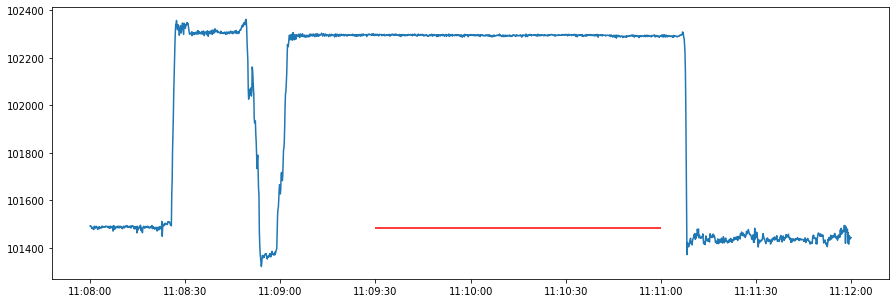

In [40]:
tmin = datetime.strptime('2023-09-29 11:08:00', '%Y-%m-%d %H:%M:%S')
tmax = datetime.strptime('2023-09-29 11:12:00', '%Y-%m-%d %H:%M:%S')

dc1 = dsp1.sel(t=slice(tmin, tmax))
# dc2 = dsp2.sel(t=slice(tmin, tmax))
# dc3 = dsp3.sel(t=slice(tmin, tmax))
# dc4 = dsp4.sel(t=slice(tmin, tmax))
# dc5 = dsp5.sel(t=slice(tmin, tmax))
# dc6 = dsp6.sel(t=slice(tmin, tmax))

plt.figure(figsize=(15,5))
plt.plot(dc1.t, dc1.p)
# plt.plot(dc2.t, dc2.p)
# plt.plot(dc3.t, dc3.p)
# plt.plot(dc4.t, dc4.p)
# plt.plot(dc5.t, dc5.p)
# plt.plot(dc6.t, dc6.p)


tbegin=datetime.strptime('2023-09-29 11:09:30', '%Y-%m-%d %H:%M:%S')
tend = datetime.strptime('2023-09-29 11:11:00', '%Y-%m-%d %H:%M:%S')

# dcc = dc.sel(t=slice(tbegin, tend))
# dc1_c = dc1.sel(t=slice(tbegin, tend))

plt.hlines(drift1, tbegin, tend, color='r')